### A. Write down the “Movie Recommendation” as a Reinforcement Learning problem formulation. Use comment lines for proper documentation

- Defining the Reward Function: In movie recommedation a rating of 4 to 5 out of 5 makes a positive reward otherthan that rating makes a negative reward.
- Each movie is a arm to pick based on it's reward distribution
- recommending movies to user and their feedback are used for reward function and based on that algorithm will learn which movies have the highest expected rewards.
  - epsilon-greedy method
  - Upper-Confidence-Bound method

1. Agent: The recommendation system
2. Environment: The user (providing the feedback)
3. Actions: Recommend a movie from a list of available movies
4. State: The user's preferences, history of watched movies, and other relevant information
5. Reward: A positive reward is given if the user watches the recommended movie and enjoys it, while a negative reward is given if the user doesn't watch the recommended movie or doesn't enjoy it
6. Goal: Maximize the cumulative reward over a period of time, by recommending movies that the user will enjoy watching

In [1]:
!pip install tf-agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 KB 73.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697659 sha256=d2199989f3e22b865f49929304bb46fa952a16018764a8dcde645abe63481c05
  Stored in directory: /root/.cache/pip/wheels/96/b9/bb/994c1324b65e39dd1cd7b8ba92e5fb766dd77980929414a866
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [2]:
#importing the modules
import tensorflow as tf
!pip install tf_agents
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities



from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools

# Agents
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent

import os
import numpy as np
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2. For the environment, use the built-in TF-agentagent, MovieLensPyEnvironment(non-per-arm)

#### matrix factorization, specifically the singular value decomposition (SVD) algorithm, to build our recommendation system.

In [3]:
# HyperParameters
BATCH_SIZE = 8
TRAINING_LOOPS = 1000
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20

In [4]:
# Paths to the data
data_path = "/content/drive/MyDrive/Artificial_Intelligence/Week-7/Datasets/ml-100k/u.data"
root_dir = '/content/drive/MyDrive/Artificial_Intelligence/Week-7/Datasets/checkpoints'

In [5]:
# Creating a MovieLensPyEnvironment Environment

env = movielens_py_environment.MovieLensPyEnvironment(
        data_path,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

### 3. Compute the regret using the built-in metric in TF-agents

In [6]:
# reward and action functions
optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)


optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)

### a. LincUCB

In [7]:

AGENT_ALPHA = 10.0
linucb = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)

### b. LinTS

In [8]:
lin_ts = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)

### c. NeuralEpsilonGreed

In [9]:
EPSILON = 0.05
LAYERS = (50, 50, 50)
LR = 0.005

network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)

neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])

In [10]:
# metrics
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

#### Training the Agent

In [11]:
def train(agent):

  if agent == 'LinUCB':
    agent = linucb
  elif agent == 'LinTS':
    agent = lin_ts
  elif agent == 'NeurEps':
    agent = neureps


  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP)

  observers = [replay_buffer.add_batch, regret_metric]

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=STEPS_PER_LOOP * BATCH_SIZE,
      observers=observers)

  regret_values = []

  for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

  return regret_values, agent

Plot the regret against 20,000-time steps using the built-in agents: 
- a.LinUCB
- b. LinTS
- c. NeuralEpsilonGreedy

And identify the best agent for the movie recommendation

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


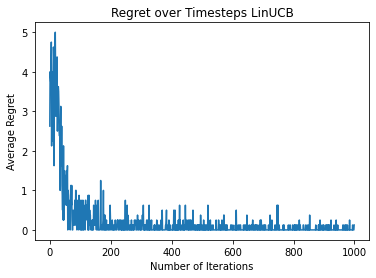

In [12]:
regret_values_linucb, linucb_agent = train('LinUCB')
plt.plot(regret_values_linucb)
plt.title('Regret over Timesteps LinUCB')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')
plt.show()

In [13]:
sum(regret_values_linucb)

<tf.Tensor: shape=(), dtype=float32, numpy=239.875>

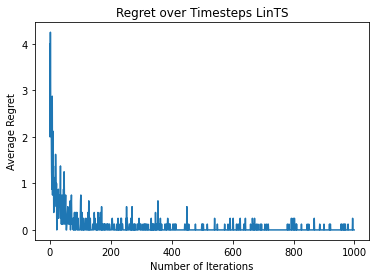

In [14]:
regret_values_lints, lints_agent = train('LinTS')
plt.plot(regret_values_lints)
plt.title('Regret over Timesteps LinTS')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')
plt.show()

In [15]:
sum(regret_values_lints)

<tf.Tensor: shape=(), dtype=float32, numpy=91.25>

Text(0, 0.5, 'Average Regret')

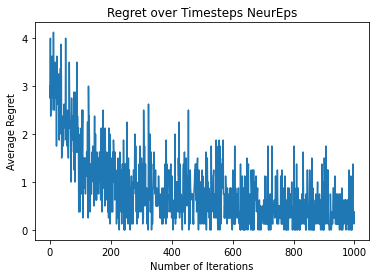

In [16]:
regret_values_neureps, neureps_agent = train('NeurEps')
plt.plot(regret_values_neureps)
plt.title('Regret over Timesteps NeurEps')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [17]:
sum(regret_values_neureps)

<tf.Tensor: shape=(), dtype=float32, numpy=867.375>

In [18]:
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)
    
    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

given a new observation request (i.e. a user vector), 
the policy will produce actions, which are the recommended movies

In [19]:
observation = np.array([1, 25, 35, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])
observation = np.expand_dims(observation, axis=0)
recommend_movies(lints_agent, observation=observation)

13